In [36]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = 5
M = 5
G = nx.generators.lattice.grid_2d_graph(N,M)

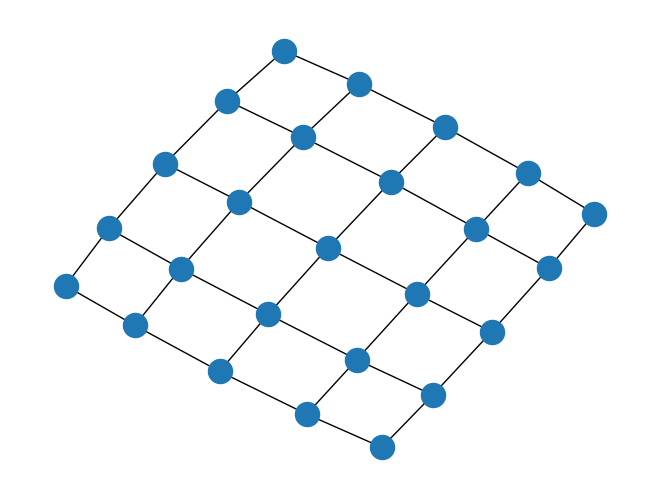

In [3]:
nx.draw(G)

In [6]:
adj_matrix = nx.adjacency_matrix(G).toarray()

In [8]:
G.edges

EdgeView([((0, 0), (1, 0)), ((0, 0), (0, 1)), ((0, 1), (1, 1)), ((0, 1), (0, 2)), ((0, 2), (1, 2)), ((0, 2), (0, 3)), ((0, 3), (1, 3)), ((0, 3), (0, 4)), ((0, 4), (1, 4)), ((1, 0), (2, 0)), ((1, 0), (1, 1)), ((1, 1), (2, 1)), ((1, 1), (1, 2)), ((1, 2), (2, 2)), ((1, 2), (1, 3)), ((1, 3), (2, 3)), ((1, 3), (1, 4)), ((1, 4), (2, 4)), ((2, 0), (3, 0)), ((2, 0), (2, 1)), ((2, 1), (3, 1)), ((2, 1), (2, 2)), ((2, 2), (3, 2)), ((2, 2), (2, 3)), ((2, 3), (3, 3)), ((2, 3), (2, 4)), ((2, 4), (3, 4)), ((3, 0), (4, 0)), ((3, 0), (3, 1)), ((3, 1), (4, 1)), ((3, 1), (3, 2)), ((3, 2), (4, 2)), ((3, 2), (3, 3)), ((3, 3), (4, 3)), ((3, 3), (3, 4)), ((3, 4), (4, 4)), ((4, 0), (4, 1)), ((4, 1), (4, 2)), ((4, 2), (4, 3)), ((4, 3), (4, 4))])

In [ ]:
def gen_random_graph(n_nodes=32, min_degree=2, max_degree=5):
    degrees = np.random.randint(min_degree, max_degree + 1, (n_nodes,))
    if degrees.sum() % 2 != 0:
        adjust_idx = np.random.randint(n_nodes)
        if degrees[adjust_idx] == min_degree:
            degrees[adjust_idx] += 1
        elif degrees[adjust_idx] == max_degree:
            degrees[adjust_idx] -= 1
        else:
            adj = np.random.choice(np.array([-1, 1]))
            degrees[adjust_idx]=degrees[adjust_idx] + adj

    rem_degrees = np.copy(degrees)

    adj_matrix = np.zeros((n_nodes, n_nodes), dtype=np.uint8)
    edges = []
    edge_indices = {}
    edge_idx = 0
    while rem_degrees.sum() != 0:
        i = np.argmax(rem_degrees).item()
        rem_degrees_gz = rem_degrees > 0
        rem_degrees_not_argmax = np.arange(rem_degrees.size) != i
        pending_edges = np.where(rem_degrees_gz & rem_degrees_not_argmax)[0]
        j = np.random.choice(pending_edges).item()

        # find a better way to do this?
        if (i, j) in edges:
            continue

        edges.append((i,j))
        edge_indices[(i,j)] = edge_idx
        edge_idx += 1
        edges.append((j,i))
        edge_indices[(j,i)] = edge_idx
        edge_idx += 1
        rem_degrees[i] -= 1
        rem_degrees[j] -= 1

    for i, j in edges:
        adj_matrix[i, j] = 1

    return adj_matrix, edge_indices

In [13]:
list(G.nodes.keys())

[(0, 0),
 (0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (1, 0),
 (1, 1),
 (1, 2),
 (1, 3),
 (1, 4),
 (2, 0),
 (2, 1),
 (2, 2),
 (2, 3),
 (2, 4),
 (3, 0),
 (3, 1),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 0),
 (4, 1),
 (4, 2),
 (4, 3),
 (4, 4)]

In [14]:
edge_indices = {}

In [30]:
nodes_list = list(G.nodes.keys())
for edge_idx, edge in enumerate(G.edges()):
    from_node, to_node = edge
    from_node_idx = nodes_list.index(from_node)
    to_node_idx = nodes_list.index(to_node)
    edge_indices[(from_node_idx, to_node_idx)] = edge_idx * 2
    edge_indices[(to_node_idx, from_node_idx)] = edge_idx * 2 + 1

In [31]:
def do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length):
    num_nodes = adj_matrix.shape[0]
    nodes = np.arange(num_nodes)
    trajectories = []
    for i in range(num_walks):
        trajectory = []
        curr_node = np.random.choice(nodes).item()
        for j in range(walk_length):
            next_node = np.random.choice(np.where(adj_matrix[curr_node] == 1)[0]).item()
            trajectory.append((curr_node, edge_indices[(curr_node, next_node)], next_node))
            curr_node = next_node
        trajectories.append(trajectory)
    return np.array(trajectories)

In [32]:
num_walks = 200
walk_length = 32
trajectories = do_graph_random_walks(adj_matrix, edge_indices, num_walks, walk_length)

In [33]:
n_obs = adj_matrix.shape[0]
n_act = len(edge_indices)
emb_dim = 1000
Q_init_stddev = 1.0
V_init_stddev = 0.1
W_init_stddev = 0.1
eta_q = 0.1
eta_v = 0.01
eta_w = 0.01
num_epochs = 10
n_obs, n_act

(25, 80)

In [34]:
np.random.seed(0)
Q = np.random.normal(size=(emb_dim, n_obs)) * Q_init_stddev
V = np.random.normal(size=(emb_dim, n_act)) * V_init_stddev
W = np.random.normal(size=(n_act, emb_dim)) * W_init_stddev

In [35]:
num_trajectories = trajectories.shape[0]
mses1 = []
for epoch in range(num_epochs):
    print(f"epoch {epoch}")
    for traj_idx in range(num_trajectories):
        nodes = trajectories[traj_idx, :, 0]
        edges = trajectories[traj_idx, :, 1]
        next_nodes = trajectories[traj_idx, :, 2]

        s_curr_DxL = Q[:, nodes]
        s_next_DxL = Q[:, next_nodes]

        s_diff_DxL = s_next_DxL - s_curr_DxL
        pred_err_DxL = s_diff_DxL - V[:, edges]

        V[:, edges] += eta_v * pred_err_DxL
        Q[:, next_nodes] += - eta_q * pred_err_DxL
        W[edges, :] += eta_w * s_diff_DxL.T
        mses1.append((pred_err_DxL ** 2).mean())

epoch 0
epoch 1
epoch 2
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
epoch 9


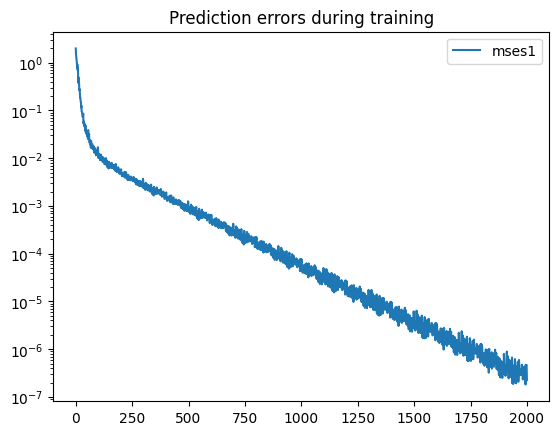

In [37]:
fig, ax = plt.subplots()
ax.plot(mses1, label='mses1')
# ax.plot(mses2, label='mses2')
ax.set_title('Prediction errors during training')
ax.set_yscale('log')
plt.legend()
plt.show()
plt.close(fig)

In [38]:
def CML_planner(start, goal, obs_size):
    a_record = []
    o_record = []
    loc = int(start)
    for i in range(obs_size):
        o_record.append(loc)
        if loc==goal:
            return i, o_record
        cur_obs = np.zeros((Q.shape[1]))
        cur_obs[loc] = 1
        goal_obs = np.zeros((Q.shape[1]))
        goal_obs[goal] = 1
        delta = Q@goal_obs - Q@cur_obs  # TODO: start and goal are one-hot vector
        avail_nodes = np.where(adj_matrix[loc] != 0)[0]  # int64
        avail_actions = [edge_indices[(loc, int(next_node))] for next_node in avail_nodes]
        utility = delta.T@V[:, avail_actions]
        # utility = delta.T@(V@(1/adj_matrix[loc, :].T))
        eligibility = utility / adj_matrix[loc][avail_nodes]
        # best_id = np.argmax(utility)
        best_id = np.argmax(eligibility)
        best_action = avail_actions[best_id]
        # best_action = edge_indices[(loc, best_id)]
        loc = int(avail_nodes[best_id])
        a_record.append(best_action)
    return i, o_record

In [40]:
N_goal = 10000
cml_distance = []
dijkstra_distance = []
graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())
for _ in range(N_goal):
    start_id = np.random.randint(0, n_obs)
    goal_id = np.random.randint(0, n_obs)
    steps, o_record = CML_planner(start_id, goal_id, n_obs)
    dijkstra_path = nx.shortest_path(graph, source=start_id, target=goal_id)
    # print(o_record, dijkstra_path)
    dijkstra_steps = len(dijkstra_path) - 1
    cml_distance.append(steps)
    dijkstra_distance.append(dijkstra_steps)
# cml_distance, dijkstra_distance
np.mean(cml_distance), np.mean(dijkstra_distance)

(np.float64(3.195), np.float64(3.195))